# "Cross-validation" des modèles

In [1]:
learning_rate = 0.05
num_epochs = 500
N = 150
N_cv = 50
seed = 42

N_test = 0
N_test = 1000
N_scan = 15

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=False)    
        self.logit0 = torch.nn.Linear(1, 1) 

    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                verbose=False):

    logistic_model = LogisticRegressionModel()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    for epoch in range(int(num_epochs)):

        optimizer.zero_grad()
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {loss.item():.5f}")

    logistic_model.eval()
    return logistic_model, loss.item()

kezako?

In [5]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.67897
Iteration: 15 - Loss: 0.60792
Iteration: 30 - Loss: 0.53192
Iteration: 45 - Loss: 0.47843
Iteration: 60 - Loss: 0.44836
Iteration: 75 - Loss: 0.43208
Iteration: 90 - Loss: 0.42292
Iteration: 105 - Loss: 0.41750
Iteration: 120 - Loss: 0.41417
Iteration: 135 - Loss: 0.41206
Iteration: 150 - Loss: 0.41070
Iteration: 165 - Loss: 0.40981
Iteration: 180 - Loss: 0.40923
Iteration: 195 - Loss: 0.40883
Iteration: 210 - Loss: 0.40856
Iteration: 225 - Loss: 0.40838
Iteration: 240 - Loss: 0.40824
Iteration: 255 - Loss: 0.40814
Iteration: 270 - Loss: 0.40807
Iteration: 285 - Loss: 0.40801
Iteration: 300 - Loss: 0.40796
Iteration: 315 - Loss: 0.40791
Iteration: 330 - Loss: 0.40787
Iteration: 345 - Loss: 0.40784
Iteration: 360 - Loss: 0.40781
Iteration: 375 - Loss: 0.40778
Iteration: 390 - Loss: 0.40775
Iteration: 405 - Loss: 0.40773
Iteration: 420 - Loss: 0.40770
Iteration: 435 - Loss: 0.40768
Iteration: 450 - Loss: 0.40766
Iteration: 465 - Loss: 0.40765
Iteration: 480 -

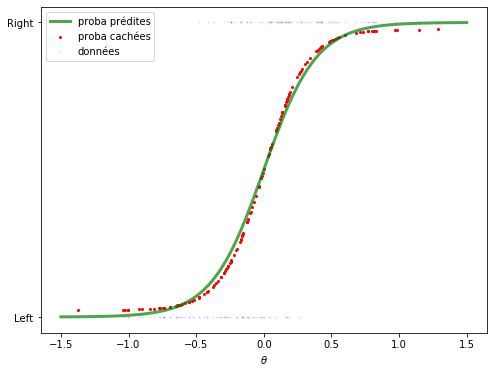

In [6]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


## validation

loss= tensor(0.4076, grad_fn=<BinaryCrossEntropyBackward>)


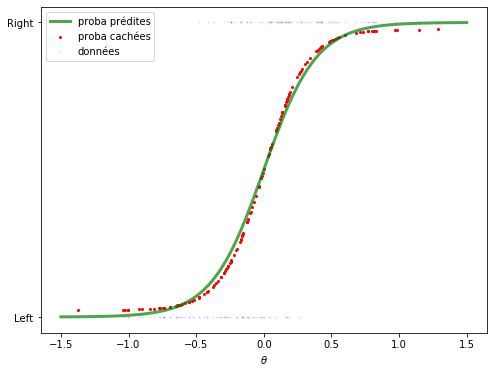

In [7]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [8]:
Ns = np.logspace(1, 3, N_scan, base=10)
Ns_, losses, KLs = [], [], []
for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}")
        Ns_.append(N_)
        KLs.append(KL)
        losses.append(loss)

N: 10, Loss: 0.40861, KL: 0.41756
N: 13, Loss: 0.38638, KL: 0.39387
N: 19, Loss: 0.40322, KL: 0.40798
N: 26, Loss: 0.39009, KL: 0.39590
N: 37, Loss: 0.39561, KL: 0.40101
N: 51, Loss: 0.38552, KL: 0.39200
N: 71, Loss: 0.38871, KL: 0.39658
N: 100, Loss: 0.38500, KL: 0.39151
N: 138, Loss: 0.40367, KL: 0.40763
N: 193, Loss: 0.38266, KL: 0.38882
N: 268, Loss: 0.38587, KL: 0.39133
N: 372, Loss: 0.38564, KL: 0.39270
N: 517, Loss: 0.38259, KL: 0.38876
N: 719, Loss: 0.38470, KL: 0.38997
N: 1000, Loss: 0.38232, KL: 0.38818


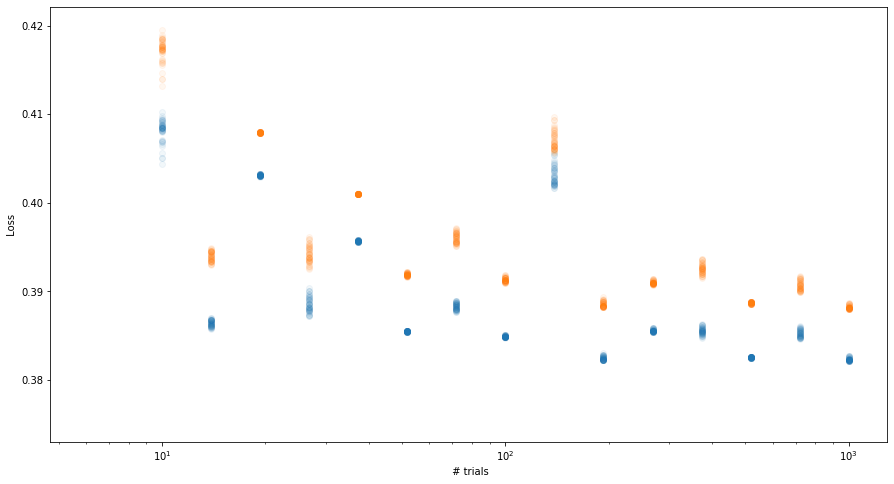

In [9]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [10]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, KLs = [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, KL: {KL:.5f}")
        learning_rates_.append(learning_rates_)
        KLs.append(KL)
        losses.append(loss)

learning_rate: 0.00500, Loss: 0.44669, KL: 0.44962
learning_rate: 0.00695, Loss: 0.42314, KL: 0.42679
learning_rate: 0.00965, Loss: 0.40472, KL: 0.40911
learning_rate: 0.01341, Loss: 0.39710, KL: 0.40223
learning_rate: 0.01864, Loss: 0.38588, KL: 0.39157
learning_rate: 0.02590, Loss: 0.38427, KL: 0.39030
learning_rate: 0.03598, Loss: 0.38413, KL: 0.39027
learning_rate: 0.05000, Loss: 0.38446, KL: 0.39098
learning_rate: 0.06947, Loss: 0.38451, KL: 0.39109
learning_rate: 0.09653, Loss: 0.38465, KL: 0.39143
learning_rate: 0.13413, Loss: 0.38476, KL: 0.39173
learning_rate: 0.18638, Loss: 0.38481, KL: 0.39188
learning_rate: 0.25897, Loss: 0.38484, KL: 0.39199
learning_rate: 0.35984, Loss: 0.38483, KL: 0.39197
learning_rate: 0.50000, Loss: 0.38485, KL: 0.39206


In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du nombre d'epochs

In [ ]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, KLs = [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, KL: {KL:.5f}")
        Ns_.append(N_)
        KLs.append(KL)
        losses.append(loss)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, KLs, alpha=3/N_cv, label='KL')

ax.set_xlabel(' # epochss')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')